In [3]:
import numpy as np
import nbimporter
from matplotlib import pyplot as plt
from collections import Counter
from scipy.optimize import curve_fit
import scipy.stats as stats
from detection_methods import fit_rotated_gaussian

In [4]:
# Define the log-normal probability density function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev)**2 / 2)

def single_value_binning(data, mindata=None, maxdata=None):
    if mindata is None:
        mindata = min(data)
    if maxdata is None:
        maxdata = max(data)

    counter = Counter(data)
    bins = range(mindata, maxdata + 1)
    hist = [counter[i]/len(data) for i in bins]

    return bins, hist


In [84]:
def outer_pixels(image_array):
    # Get the dimensions of the image
    height, width = image_array.shape[:2]

    # Calculate the bounds of the inner 25% of the image
    inner_radius=int(height*0.4)

    # Initialize an empty list to store outer pixel values
    outer_pixel_values = []

    fit_params,_ =fit_rotated_gaussian(image_array)
    pos_x=fit_params[2]
    pos_y=fit_params[1]

    visualization=np.zeros(image_array.shape)

    # Iterate through each pixel in the image
    for i in range(height):
        for j in range(width):
            if (i-pos_x)**2+(j-pos_y)**2>inner_radius**2:
                pixel_value = image_array[i, j]
                visualization[i, j]=pixel_value
                outer_pixel_values.append(pixel_value)

    return outer_pixel_values, visualization


In [85]:
filename='data/10Hz_oscillation/100nm.npy'
movie = np.load(filename)

In [86]:
outer_pixel_values, visualization=outer_pixels(movie[0])

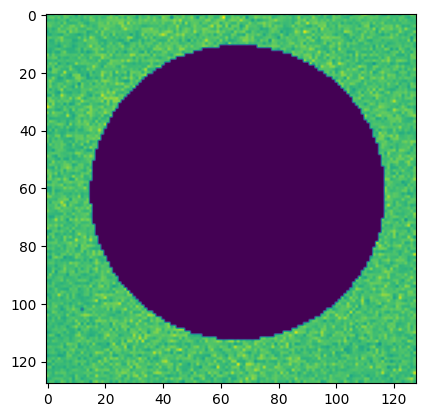

In [87]:
plt.imshow(visualization)

In [110]:
data=[]
for frame in movie:
    outer_pixel_values, visualization=outer_pixels(frame)
    data.extend(outer_pixel_values)

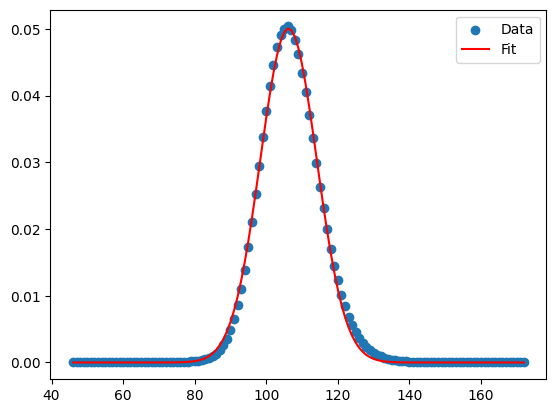

In [120]:

# perform the fit using curve_fit from scipy.optimize
initial_guess = [max(hist),bins[np.argmax(hist)], 10]
fit_params, cov_matrix = curve_fit(gaussian, bins, hist, p0=initial_guess)

# extract the fit parameters and their uncertainties
fit_amplitude, fit_mean, fit_stddev = fit_params
fit_amplitude_err, fit_mean_err, fit_stddev_err = np.sqrt(np.diag(cov_matrix))

fig, ax = plt.subplots()
ax.scatter(bins, hist, label='Data')
ax.plot(bins, gaussian(bins, fit_amplitude, fit_mean, fit_stddev), label='Fit', color='red')
ax.legend()


In [121]:
print(f'Amplitude: {fit_amplitude:.3f} ± {fit_amplitude_err:.3f}')
print(f'Mean:      {fit_mean:.3f} ± {fit_mean_err:.3f}')
print(f'Std dev:   {fit_stddev:.3f} ± {fit_stddev_err:.3f}')

Amplitude: 0.050 ± 0.000
Mean:      106.226 ± 0.039
Std dev:   7.897 ± 0.039
